In [1]:
# !pip install -U matplotlib --quiet
# !pip install torch --quiet
# !pip install lightning --quiet

In [2]:
# !git clone https://github.com/QMCSoftware/QMCSoftware
# !cd QMCSoftware && git checkout qmctoolscl_integration
# !cd QMCSoftware && git pull
# !cd QMCSoftware && pip install -e .

# CHONKNORIS for a 1 dimensional non-linear elliptic PDE

Here we will solve the PDE

$$\begin{cases} C_1 v^3 + C_2 \Delta v = u, & x \in [0,1] \\ v = 0, &x \in \partial [0,1]^d \end{cases}$$

where $\Delta$ is the Laplacian, $u$ is random and $v$ is the unknown PDE solution.    

In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1' # cholesky not implemented on MPS, fall back to CPU
import torch

In [2]:
# may need to Runtime > Restart session if loading for the first time on Google Colab
import torch
import qmcpy as qp
import pandas as pd
import numpy as np
import lightning
import time
from collections import OrderedDict
import os
import glob
import warnings
from typing import List

In [3]:
ROOT = "./CHONKNORIS/elliptic_pde_1d"

In [4]:
assert torch.cuda.is_available() or torch.backends.mps.is_available()
DEVICE = "cuda" if torch.cuda.is_available() else "mps"
DEVICE

'mps'

In [5]:
from matplotlib import pyplot,cm,colors,gridspec
#print(pyplot.style.available)
pyplot.style.use('seaborn-whitegrid') 
LW = 3 # linewidth
LWTHIN = 0.01
COLORS = ["xkcd:"+color[:-1] for color in pd.read_csv("./xkcd_colors.txt",comment="#").iloc[:,0].tolist()]

## Reference Solution

We will randomly generate $v$ from
$$\exp\left(-\frac{1}{1-r^2}\right)\left[\sum_{p=1}^P a_p \sin(p \pi x)\right] 1_{x \in (0,1)}$$
where $r=2x-1$ and $(a_1,\dots,a_P) \sim \mathcal{U}[-\overline{B},\underline{B}]^P$. We will use auto-diff to find $u$.

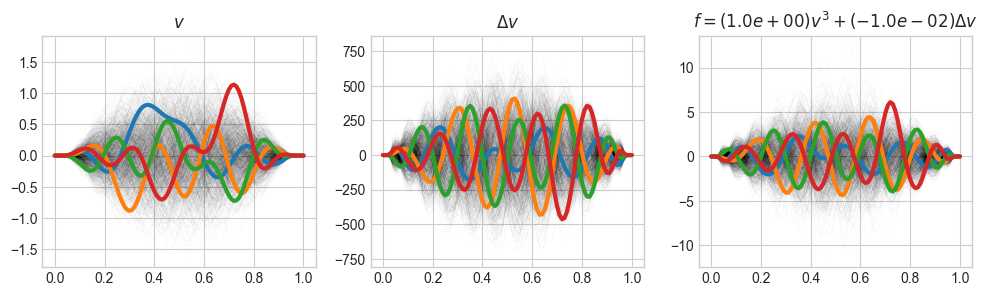

In [6]:
C1 = 1.
C2 = -1./100
def v(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    P = len(a)
    assert a.shape==(P,)
    y = torch.zeros_like(x)
    r = 2*x-1
    b = torch.abs(r)<1
    t1 = torch.exp(-1/(1-r[b]**2))
    t2 = (a[:,None]*torch.sin(torch.arange(1,P+1)[:,None]*torch.pi*x[None,b])).sum(0)
    y[b] = t1*t2
    return y
def v_laplace(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    xg = x.clone().requires_grad_()
    yg = v(xg,a)
    grad_outputs = torch.ones_like(x)
    ypg = torch.autograd.grad(yg,xg,grad_outputs,create_graph=True)[0]
    yppg = torch.autograd.grad(ypg,xg,grad_outputs,create_graph=True)[0]
    return yppg.detach()
def u(x, a=torch.tensor([1.,0.,0.,1/2],dtype=float)):
    return C1*v(x,a)**3+C2*v_laplace(x,a)
R = 2**10
P = 10
B_low = -1.
B_high = 1.
dnb2 = qp.DigitalNetB2(P,seed=7,graycode=True)
unif_dnb2 = qp.Uniform(dnb2,lower_bound=B_low,upper_bound=B_high)
a = torch.from_numpy(unif_dnb2.gen_samples(R))
nxticks = 101
xticks = torch.linspace(0,1,nxticks,dtype=float)
vticks = torch.vstack([v(xticks,a=a[r]) for r in range(R)])
vlticks = torch.vstack([v_laplace(xticks,a=a[r]) for r in range(R)])
uticks = torch.vstack([u(xticks,a=a[r]) for r in range(R)])
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,3))
coloridxs = torch.arange(4)
ax[0].plot(xticks,vticks.T,color='k',linewidth=LWTHIN)
ax[1].plot(xticks,vlticks.T,color='k',linewidth=LWTHIN)
ax[2].plot(xticks,uticks.T,color='k',linewidth=LWTHIN)
ax[0].plot(xticks,vticks.T[:,coloridxs],linewidth=LW)
ax[1].plot(xticks,vlticks.T[:,coloridxs],linewidth=LW)
ax[2].plot(xticks,uticks.T[:,coloridxs],linewidth=LW)
ax[0].set_title(r"$v$")
ax[1].set_title(r"$\Delta v$")
ax[2].set_title(r"$f = (%.1e) v^3 + (%.1e) \Delta v$"%(C1,C2));

## GP for PDE Solves

In [7]:
llbetas = [ # derivative orders
    [ # interior
        torch.tensor([[0]],dtype=int), # v
        torch.tensor([[2]],dtype=int), # laplacian v
    ],
    [ # boundary
        torch.tensor([[0]],dtype=int) # v
    ]
]
llcs = [ # summand of derivatives coefficients
    [ # interior
        torch.ones(1,dtype=float), # v
        torch.ones(1,dtype=float) # laplacian v
    ],
    [ # boundary
        torch.ones(1,dtype=float) # v
    ]
]
xs = [xticks[:,None],torch.tensor([[0],[1]],dtype=float)]

In [8]:
noise = 1e-8
lattice = qp.Lattice(dimension=1,seed=7) # collocation points
#kernel = qp.KernelShiftInvar(dimension=1,lengthscales=1e-1,alpha=4,scale=1.,torchify=True) # kernel
kernel = qp.KernelGaussian(dimension=1,lengthscales=1e-3,scale=1.,torchify=True) # kernel
ki = qp.PDEGramMatrix(kernel,xs,None,None,llbetas,llcs,noise) # kernel interpolant

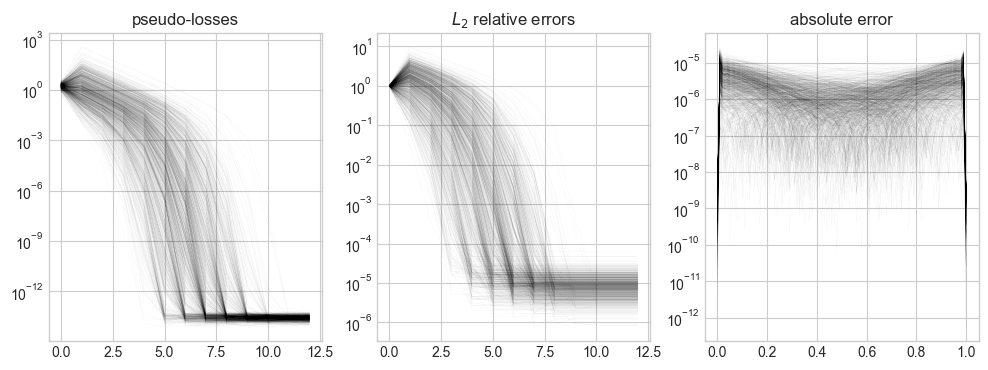

In [9]:
kvec = ki.get_new_left_full_gram_matrix(xticks[:,None])
def get_data(maxiter=10, tag="full", force_gen=False):
    fname = "%s/%s.%s"%(ROOT,"elliptic_pde_1d_data",tag)
    if (not os.path.exists(fname+".npz")) or force_gen:
        data = {
            "vopt": np.empty((R,maxiter+1,ki.length)),
            "losses_opt": np.empty((R,maxiter+1)),
            "vhats": np.empty((R,maxiter+1,nxticks)),
            "l2relerrors": np.empty((R,maxiter+1)),
            "L_chols": np.empty((R,maxiter,ki.ntot,ki.ntot))}
        print("r from 0 to %d, l2 relative errors\n"%(R)+"~"*100)
        verbosity = R//8
        for r in range(R):
            if (r+1)%verbosity==0: print("r = %d: "%(r+1),end='',flush=True)
            def pde_lhs_r(ly_i, ly_b):
                v_i,v_laplace_i = ly_i
                v_b = ly_b[0]
                lhs_i = C1*v_i**3+C2*v_laplace_i
                lhs_b = v_b
                return lhs_i,lhs_b
            def pde_rhs_r(x_i, x_b):
                y_i = uticks[r]
                y_b = torch.zeros(len(x_b),dtype=float)
                return y_i,y_b
            y,data_r = ki.pde_opt_gauss_newton(
                pde_lhs = pde_lhs_r,
                pde_rhs = pde_rhs_r,
                maxiter = maxiter,
                store_L_chol_hist = True,
                verbose = False)
            data["vopt"][r] = data_r["zhist"].numpy()
            data["losses_opt"][r] = data_r["losses"].numpy()
            data["vhats"][r] = (kvec@ki._solve(data_r["zhist"].T)).T.numpy()
            data["l2relerrors"][r] = (torch.linalg.norm(data_r["zhist"][:,:nxticks]-vticks[r],dim=1)/torch.linalg.norm(vticks[r])).numpy()
            data["L_chols"][r] = data_r["L_chol_hist"].numpy()
            if (r+1)%verbosity==0:
                with np.printoptions(precision=1,threshold=8):
                    print(data["l2relerrors"][r])
        np.savez_compressed(fname,**data)
    data = np.load(fname+".npz")
    return (
        torch.from_numpy(data["vopt"]),
        torch.from_numpy(data["losses_opt"]),
        torch.from_numpy(data["l2relerrors"]),
        torch.from_numpy(data["L_chols"]))
maxiter = 12
vopt,losses_opt,l2rerrs,L_chols = get_data(maxiter=maxiter,tag="full",force_gen=False)
best_idxs = losses_opt.argmin(1)
vopt_best = vopt[np.arange(R),best_idxs,:]
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=(12,4))
ax[0].set_title("pseudo-losses")
ax[0].plot(torch.arange(losses_opt.size(1)),losses_opt.T,color="k",linewidth=LWTHIN)
ax[0].set_yscale("log",base=10)
ax[1].set_title(r"$L_2$ relative errors")
ax[1].plot(torch.arange(l2rerrs.size(1)),l2rerrs.T,color="k",linewidth=LWTHIN)
ax[1].set_yscale("log",base=10)
ax[2].set_title("absolute error")
ax[2].plot(xticks,torch.abs(vopt_best[:,:nxticks]-vticks).T,color="k",linewidth=LWTHIN)
ax[2].set_yscale("log",base=10);

/Users/agsorok/miniconda3/envs/qmcpy/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:140
/Users/agsorok/miniconda3/envs/qmcpy/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:140


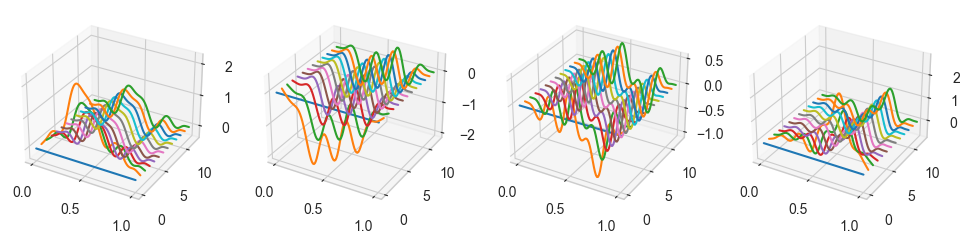

In [10]:
plt_idxs = [0,1,2,3]
ncols = len(plt_idxs)
fig = pyplot.figure(figsize=(12,4))
ax = np.empty(ncols,dtype=object)
_gs = gridspec.GridSpec(1,ncols)
for i in range(ncols): ax[i] = fig.add_subplot(_gs[0,i],projection="3d")
for i in range(ncols):
    for k in range(vopt.size(1)):
        ax[i].plot(xticks,k*torch.ones_like(xticks),vopt[plt_idxs[i],k,:nxticks])

## Training and Validation Dataloaders

In [11]:
val_frac = 1/8
tv_idx = torch.arange(R)#torch.from_numpy(dnb2.rng.permutation(R))
n_train = R-int(val_frac*R)
n_val = R-n_train
tidx = tv_idx[:n_train]
vidx = tv_idx[n_train:]
print("number train u: %d"%n_train)
print("number val   u: %d\n"%n_val)
uticks_train = uticks[tidx]
uticks_val = uticks[vidx]
vopt_train = vopt[tidx]
vopt_val = vopt[vidx]
vticks_train = vticks[tidx]
vticks_val = vticks[vidx]
L_chols_train = L_chols[tidx]
L_chols_val = L_chols[vidx]
print("uticks_train.shape:",tuple(uticks_train.shape))
print("vopt_train.shape:",tuple(vopt_train.shape))
print("vticks_train.shape:",tuple(vticks_train.shape))
print("L_chols_train.shape:",tuple(L_chols_train.shape))
print()
print("uticks_val.shape:",tuple(uticks_val.shape))
print("vopt_val.shape:",tuple(vopt_val.shape))
print("vticks_val.shape:",tuple(vticks_val.shape))
print("L_chols_val.shape:",tuple(L_chols_val.shape))

number train u: 896
number val   u: 128

uticks_train.shape: (896, 101)
vopt_train.shape: (896, 13, 204)
vticks_train.shape: (896, 101)
L_chols_train.shape: (896, 12, 103, 103)

uticks_val.shape: (128, 101)
vopt_val.shape: (128, 13, 204)
vticks_val.shape: (128, 101)
L_chols_val.shape: (128, 12, 103, 103)


In [24]:
class DatasetCHONKNORIS(torch.utils.data.Dataset):
    def __init__(self, v, L_chols, device="cpu", steps="all", fp32=False, interior_only=False):
        self.v = v[:,:,:nxticks] if interior_only else v
        self.L_chols = L_chols
        if fp32:
            self.v = self.v.to(torch.float32)
            self.L_chols = self.L_chols.to(torch.float32)
        steps = self.L_chols.size(1) if steps=="all" else steps
        self.i_r,self.i_k = torch.cartesian_prod(torch.arange(self.L_chols.size(0)),torch.arange(steps)).T
        self._put_on_device(device)
    def _put_on_device(self, device):
        self.i_r,self.i_k = self.i_r.to(device),self.i_k.to(device)
        self.v,self.L_chols = self.v.to(device),self.L_chols.to(device)
    def __getitems__(self, i):
        i = torch.tensor(i,dtype=torch.int)
        ir,ik = self.i_r[i],self.i_k[i]
        return self.v[ir,ik,:],self.L_chols[ir,ik,:]
    def __len__(self):
        return len(self.i_r)
dataset_train = DatasetCHONKNORIS(vopt_train,L_chols_train,device=DEVICE,steps=maxiter,fp32=True,interior_only=True)
dataset_val = DatasetCHONKNORIS(vopt_val,L_chols_val,device=DEVICE,fp32=True,interior_only=True)
dataloader_train = torch.utils.data.DataLoader(dataset_train,batch_size=2**8,collate_fn=tuple,shuffle=True)
dataloader_val = torch.utils.data.DataLoader(dataset_val,batch_size=len(dataset_val),collate_fn=tuple,shuffle=False)

## Neural Operator

### MLP

In [25]:
class MultilayerPerceptron(torch.nn.Module):
    def __init__(self, mlp_layer_nodes:list, activation_function:torch.nn.Module=torch.nn.Tanh(), activate_last_layer:bool=False, scale_last_layer:bool=True, bias_last_layer:bool=True, weight_init_scheme:callable=None):
        super().__init__()
        num_layers = len(mlp_layer_nodes)-1
        self.mlp_layer_nodes = mlp_layer_nodes
        self.output_nodes = self.mlp_layer_nodes[-1]
        layers = []
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore",".*Initializing zero-element tensors is a no-op*") # occurs when setting a layer with 0 inputs
            for i in range(num_layers):
                layer = torch.nn.Linear(self.mlp_layer_nodes[i],self.mlp_layer_nodes[i+1])
                if callable(weight_init_scheme):
                    weight_init_scheme(layer.weight)
                layer.bias.data.fill_(0. if self.mlp_layer_nodes[i]>0 else 1.)
                layers.extend([layer,activation_function])
        self.mlp_sequential = torch.nn.Sequential(*(layers if activate_last_layer else layers[:-1]))
        self.logscale,self.bias = torch.tensor(0.),torch.tensor(0.)
        if scale_last_layer: self.logscale = torch.nn.parameter.Parameter(self.logscale)
        if bias_last_layer: self.bias = torch.nn.parameter.Parameter(self.bias)
    def output_transform(self, x:torch.Tensor):
        return x
    def forward(self, x):
        x = self.mlp_sequential(x).squeeze()
        x = self.output_transform(x)
        return torch.exp(self.logscale)*x+self.bias

### NORIS Lightning

In [158]:
class NORISLightning(lightning.LightningModule):
    def __init__(self, mlp, automatic_optimization=True, loss_metric="KL", kl_flip=True, frob_loss_alpha=.5):
        super().__init__()
        self.mlp = mlp
        self.automatic_optimization = automatic_optimization
        self.loss_metric = loss_metric.upper()
        self.kl_flip = kl_flip
        self.ftype = self.mlp.mlp_sequential[0].weight.dtype
        self.s0 = self.mlp.mlp_sequential[0].weight.size(1)
        self._tril_i0,self._tril_i1 = torch.tril_indices(nxticks+2,nxticks+2)
        self._diag_i = torch.arange(nxticks+2)
        self.frob_loss_alpha = frob_loss_alpha
        assert 0<self.frob_loss_alpha<1
    def to(self, device):
        super().to(device)
        self.mlp.to(device)
        self._tril_i0,self._tril_i1,self._diag_i = self._tril_i0.to(device),self._tril_i1.to(device),self._diag_i.to(device)
    def forward(self, v):
        isv1d = v.ndim==1
        v = torch.atleast_2d(v)
        L_chol_hat = torch.zeros((v.size(0),nxticks+2,nxticks+2),dtype=self.ftype,device=self._tril_i0.device)
        L_chol_hat[:,self._tril_i0,self._tril_i1] = self.mlp(v[:,:self.s0])
        # set diagonal to exp(x-1) if x<1 and leave as x otherwise
        diags = L_chol_hat[:,self._diag_i,self._diag_i]
        diags[diags<1] = torch.exp(diags[diags<1]-1)
        L_chol_hat[:,self._diag_i,self._diag_i] = diags
        return L_chol_hat[0] if isv1d else L_chol_hat
    def frob_norm(self, L_chol, L_chol_hat):
        ogndim = L_chol.ndim
        assert ogndim in [2,3]
        if ogndim==2:
            L_chol = L_chol[None,:,:]
            L_chol_hat = L_chol_hat[None,:,:]
        assert L_chol.ndim==3 and L_chol_hat.ndim==3
        fnorms = torch.sqrt(((L_chol[:,self._tril_i0,self._tril_i1]-L_chol_hat[:,self._tril_i0,self._tril_i1])**2).sum(1))
        return fnorms[0] if ogndim==2 else fnorms 
    def kl_div(self, L_chol, L_chol_hat, kl_flip=None):
        if kl_flip is None: kl_flilp = self.kl_flip
        ogndim = L_chol.ndim
        assert ogndim in [2,3]
        if ogndim==2:
            L_chol = L_chol[None,:,:]
            L_chol_hat = L_chol_hat[None,:,:]
        assert L_chol.ndim==3 and L_chol_hat.ndim==3
        det2_true = 2*torch.log(L_chol.diagonal(dim1=-1,dim2=-2)).sum(-1)
        det2_pred = 2*torch.log(L_chol_hat.diagonal(dim1=-1,dim2=-2)).sum(-1)
        if self.kl_flip:
            L_chol_hat_T = torch.transpose(L_chol_hat,-2,-1)
            theta_hat = torch.bmm(L_chol_hat,L_chol_hat_T)
            t = torch.cholesky_solve(theta_hat,L_chol)
            traces = t.diagonal(dim1=-1,dim2=-2).sum(-1)
            det_diff = det2_true-det2_pred
        else:
            L_chol_T = torch.transpose(L_chol,-2,-1)
            theta = torch.bmm(L_chol,L_chol_T)
            t = torch.cholesky_solve(theta,L_chol_hat)
            traces = t.diagonal(dim1=-1,dim2=-2).sum(-1)
            det_diff = det2_pred-det2_true
        kls = 1/2*(det_diff-L_chol.size(-1)+traces)
        return kls
    def _common_step(self, batch, tag):
        v,L_chol = batch
        L_chol_hat = self.forward(v)
        if self.loss_metric=="FROB": # mean (Frobineous norm)
            loss = torch.mean(self.frob_norm(L_chol,L_chol_hat))
        elif self.loss_metric=="KL": # mean (KL div)
            loss = torch.mean(self.kl_div(L_chol,L_chol_hat))
        elif self.loss_metric=="FROB_KL": # mean ( frob_loss_alpha*(Frobineious norm) + (1-frob_loss_alpha)*(KL div) )
            frobs = self.frob_norm(L_chol,L_chol_hat)
            kls = self.kl_div(L_chol,L_chol_hat)
            loss = torch.mean(2*(self.frob_loss_alpha*frobs+(1-self.frob_loss_alpha)*kls))
        else:
            raise Exception("loss_metric must be either 'FROB' or 'KL'")
        self.log(tag+"_loss",loss,prog_bar=tag!="val",logger=True,sync_dist=True,on_step=False,on_epoch=True)
        return loss
    def training_step(self, batch, batch_idx):
        if self.automatic_optimization:
            return self._common_step(batch,tag="train")
        else:
            opt = self.optimizers()
            def closure():
                loss = self._common_step(batch,tag="train")
                opt.zero_grad(set_to_none=True)
                self.manual_backward(loss)
                return loss
            opt.step(closure=closure)
    def validation_step(self, batch, batch_idx):
        with torch.inference_mode(True):
          return self._common_step(batch,tag="val")
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(),lr=1e-3,amsgrad=True)
        # if self.trainer.current_epoch>=2000:
        #     optimizer = torch.optim.LBFGS(self.parameters())#,lr=1e-2,amsgrad=True)
        return optimizer

### Training

In [164]:
import gc
gc.collect()
torch.cuda.empty_cache()
save_dir = ROOT+"/"
name = "NORIS_fp64"
resume = True
mlp = MultilayerPerceptron(
    mlp_layer_nodes = [nxticks,250,(1+(nxticks+2))*(nxticks+2)//2],
    #activation_function = torch.nn.ReLU(),
    #activation_function = torch.nn.Tanh(),
    activation_function = torch.nn.SiLU(),
    #weight_init_scheme = torch.nn.init.kaiming_normal_
)
noris_lightning = NORISLightning(mlp,loss_metric="FROB_KL")
print("number train: %.2e"%len(dataset_train))
print("number val  : %.2e"%len(dataset_val))
print(noris_lightning)
csv_logger = lightning.pytorch.loggers.CSVLogger(save_dir=save_dir,name=name,version='csv')
trainer = lightning.Trainer(
    max_epochs = 100,
    logger = [csv_logger],
    #accelerator = "cpu",
    #limit_train_batches=2**10,
    #log_every_n_steps = 1e10,
    enable_progress_bar = True,
    #num_sanity_val_steps = 0,
    gradient_clip_val = 0.0,
    gradient_clip_algorithm = "norm",
  )
trainer.fit(
    model = noris_lightning, 
    train_dataloaders = dataloader_train,
    val_dataloaders = dataloader_val,
    ckpt_path = sorted(glob.glob("./%s/%s/csv/checkpoints/*.ckpt"%(save_dir,name)),key=os.path.getmtime)[-1] if resume else None,
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/agsorok/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/fabric/loggers/csv_logs.py:268: Experiment logs directory ./CHONKNORIS/elliptic_pde_1d/NORIS_fp64/csv exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/Users/agsorok/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory ./CHONKNORIS/elliptic_pde_1d/NORIS_fp64/csv/checkpoints exists and is not empty.
Restoring states from the checkpoint path at ././CHONKNORIS/elliptic_pde_1d//NORIS_fp64/csv/checkpoints/epoch=24-step=1050-v3.ckpt

  | Name | Type                 | Params | Mode 
------------------------------------------------------
0 | mlp  | MultilayerPerceptron | 1.4 M  | train
------------------------------------------------------
1.4 M     Trainable params
0         Non-

number train: 1.08e+04
number val  : 1.54e+03
NORISLightning(
  (mlp): MultilayerPerceptron(
    (mlp_sequential): Sequential(
      (0): Linear(in_features=101, out_features=250, bias=True)
      (1): SiLU()
      (2): Linear(in_features=250, out_features=5356, bias=True)
    )
  )
)


Sanity Checking: |                                                                                            …

/Users/agsorok/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/agsorok/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/agsorok/miniconda3/envs/qmcpy/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

Validation: |                                  | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


,train_loss,val_loss
1,372.156036,371.491547
8,347.871796,337.938629
15,328.533264,351.683960
22,318.017334,345.413727
29,302.116821,323.264099
36,309.533417,310.768250
43,291.193512,273.406372
50,257.423309,298.008850
57,274.915405,247.750656
64,256.266632,313.970398


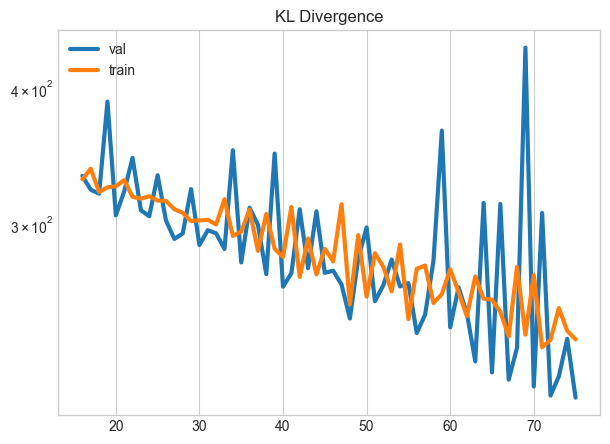

In [165]:
metrics = pd.read_csv("%s/%s/csv/metrics.csv"%(save_dir,name))
metrics
metrics_train = metrics.iloc[~np.isnan(metrics["train_loss"].values)]
metrics_val = metrics.iloc[~np.isnan(metrics["val_loss"].values)]
metrics
parsed_metrics = {
    "train_loss": metrics_train["train_loss"].values,
    "val_loss": metrics_val["val_loss"].values,
}
metrics = pd.DataFrame(parsed_metrics)
metrics.index = metrics.index+1
fig,ax = pyplot.subplots(nrows=1,ncols=1,figsize=(7,5))
ax.set_title(r"Loss")
epochs = len(metrics.index)
plt_epochs = metrics.index[epochs//5:]
ax.plot(plt_epochs,metrics["val_loss"][plt_epochs],label="val",linewidth=LW)
ax.plot(plt_epochs,metrics["train_loss"][plt_epochs],label="train",linewidth=LW)
ax.legend()
ax.set_yscale("log",base=10);
metrics.iloc[::max(1,len(metrics)//10)]

## Inference

In [167]:
noris_lightning.to("cpu")

In [168]:
ridxs = [0,1,2,7,8]
maxiter = 3
numrs = len(ridxs)
vhat = [None]*numrs
numpreds = maxiter+1
for i,r in enumerate(ridxs): 
    def pde_lhs_r(ly_i, ly_b):
        v_i,v_laplace_i = ly_i
        v_b = ly_b[0]
        lhs_i = C1*v_i**3+C2*v_laplace_i
        lhs_b = v_b
        return lhs_i,lhs_b
    def pde_rhs_r(x_i, x_b):
        y_i = uticks_val[r]
        y_b = torch.zeros(len(x_b),dtype=float)
        return y_i,y_b
    y,data_r = ki.pde_opt_gauss_newton(
        pde_lhs = pde_lhs_r,
        pde_rhs = pde_rhs_r,
        maxiter = maxiter,
        store_L_chol_hist = True,
        predictor_L_chol = lambda v: noris_lightning.forward(v.to(torch.float32)).detach().to(torch.float64),
        verbose = False)
    vhat[i] = data_r["zhist"][:,:nxticks]
    # print(L_chols_val[r][0])
    # print(data_r["L_chol_hist"][0])
    # print(noris_lightning.kl_div(L_chols_val[r],data_r["L_chol_hist"]))
    # print(data_r["zhist"])
vhat = torch.stack(vhat)
l2rerrors = torch.linalg.norm(vhat-vticks_val[ridxs,None,:],dim=2)/torch.linalg.norm(vticks_val[ridxs,None,:],dim=2)
l2rerrors_iter = torch.linalg.norm(vhat-vopt_val[ridxs,:numpreds,:nxticks],dim=2)/torch.linalg.norm(vopt_val[ridxs,:numpreds,:nxticks],dim=2)
aerrors = torch.abs(vhat[:,-1,:]-vticks_val[ridxs,:])
l2rerrors_iter

tensor([[       nan, 8.9261e-01, 1.3084e+00, 2.4648e+06],
        [       nan, 8.5645e-01, 4.5215e+01, 2.7377e+28],
        [       nan, 7.8522e-01, 2.7863e+01, 7.2257e+39],
        [       nan, 8.6251e-01, 1.9687e+00, 8.4406e+16],
        [       nan, 7.9722e-01, 5.0306e+00, 8.2672e+14]], dtype=torch.float64)

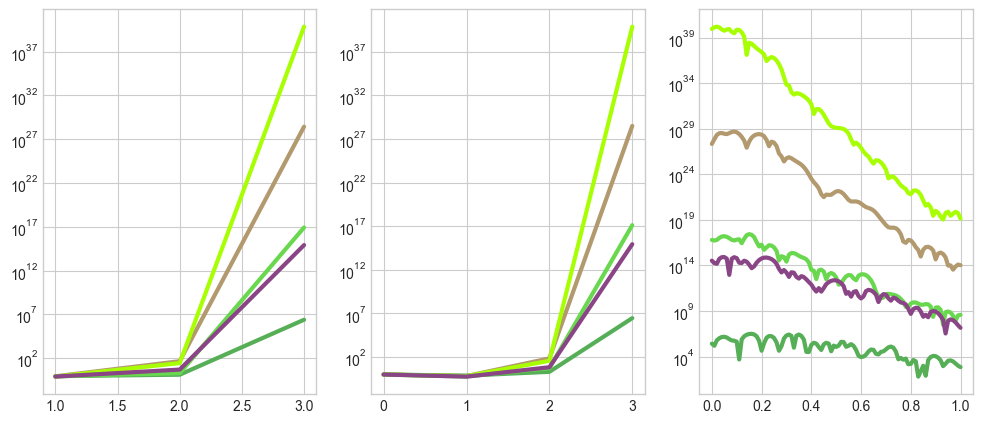

In [169]:
fig,ax = pyplot.subplots(nrows=1,ncols=3,figsize=((12,5)))
for i in range(numrs):
    ax[0].plot(torch.arange(numpreds),l2rerrors_iter[i],linewidth=LW,color=COLORS[i])
    ax[1].plot(torch.arange(numpreds),l2rerrors[i],linewidth=LW,color=COLORS[i])
    ax[2].plot(xticks,aerrors[i],linewidth=LW,color=COLORS[i])
for i in range(3):
    ax[i].set_yscale("log",base=10)

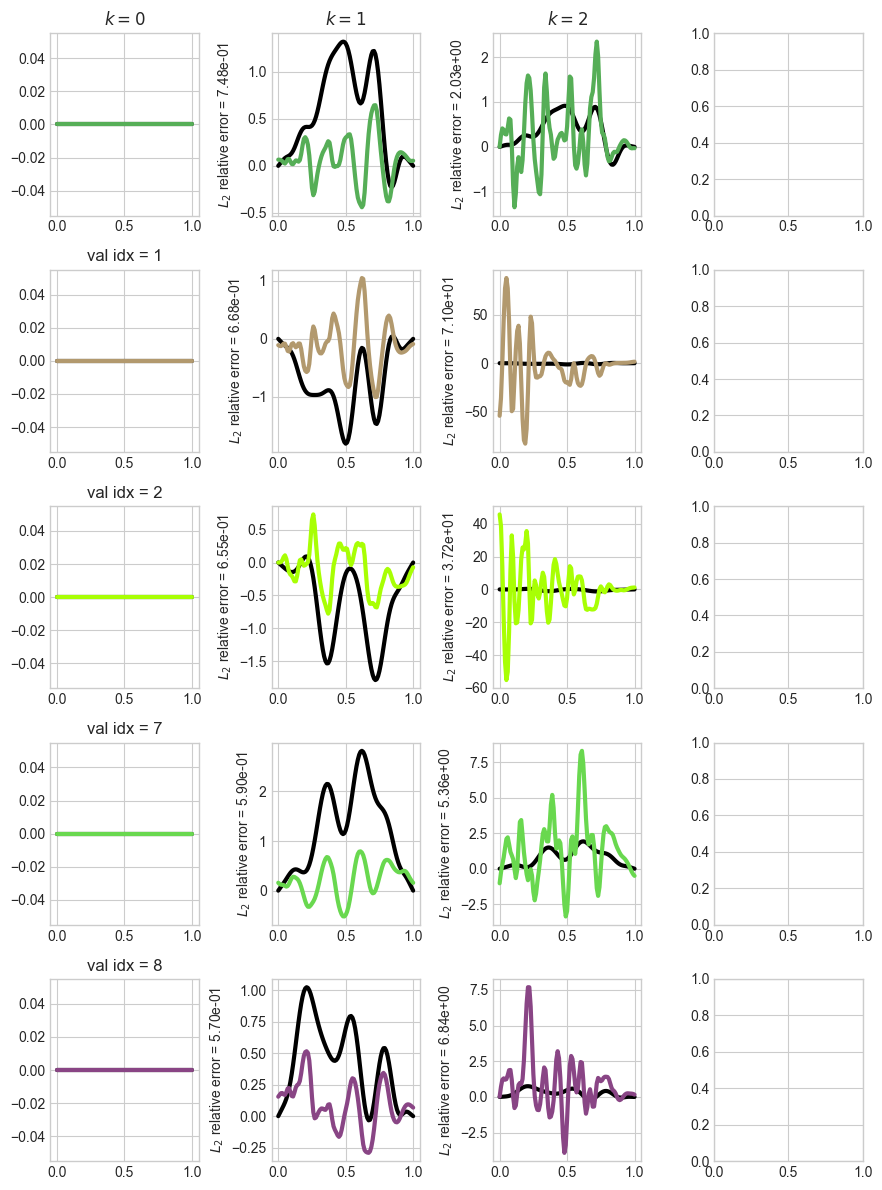

In [170]:
fig,ax = pyplot.subplots(nrows=numrs,ncols=numpreds,figsize=(3*ncols,3*nrows))
for i in range(numrs):
    #ymin,ymax = vhat[i,:,:nxticks].min(),vhat[i,:,:nxticks].max()
    ymin,ymax = vhat.min(),vhat.max()
    yymin,yymax = ymin-(ymax-ymin)*.1,ymax+(ymax-ymin)*.1
    for k in range(ncols):
        ax[i,k].plot(xticks,vopt_val[ridxs[i],k,:nxticks],linewidth=LW,color="k")
        ax[i,k].plot(xticks,vhat[i,k,:nxticks],linewidth=LW,color=COLORS[i])
        #ax[i,k].set_ylim([yymin,yymax])
        if k>0:
            ax[i,k].set_ylabel(r"$L_2$ relative error = %.2e"%l2rerrors[i,k])
for i in range(numrs):
    ax[i,0].set_title("val idx = %d"%ridxs[i])
for k in range(ncols):
    ax[0,k].set_title(r"$k = %d$"%k)
fig.tight_layout()

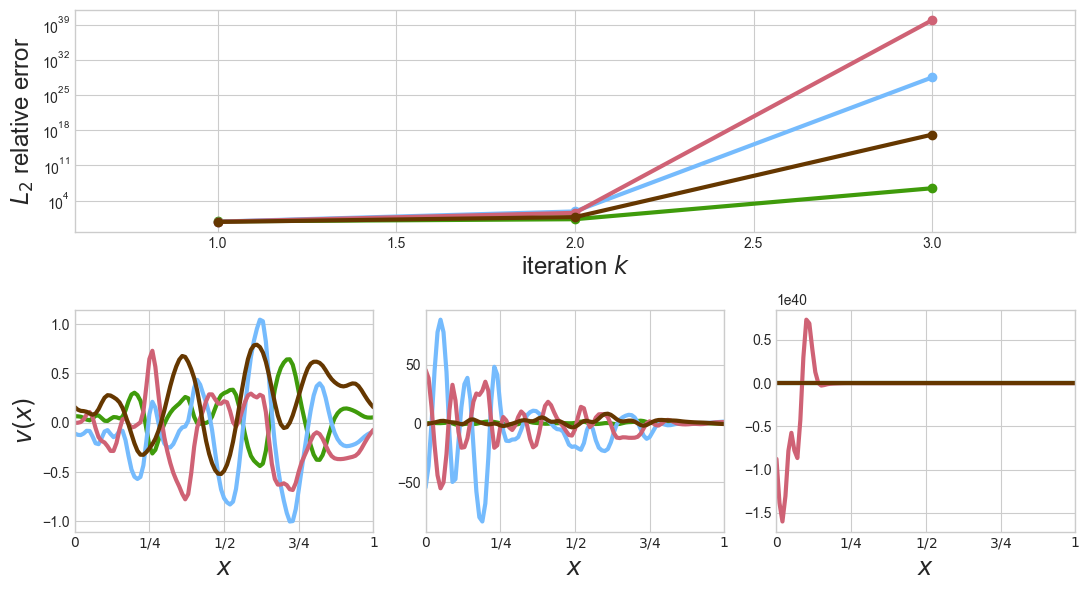

In [171]:
fig = pyplot.figure(figsize=(11,6))
_gs = gridspec.GridSpec(2,numpreds-1) 
CUSTOMCOLORS = ["xkcd:grass green","xkcd:sky blue","xkcd:rose","xkcd:brown"]+COLORS
ax = fig.add_subplot(_gs[0,:])
for i in range(nrows):
    ax.plot(torch.arange(1,numpreds),l2rerrors[i,1:],marker="o",linewidth=LW,color=CUSTOMCOLORS[i])
ax.set_yscale("log",base=10)
ax.set_xlim([.6,numpreds-.6])
ax.set_xlabel(r"iteration $k$",fontsize="xx-large")
ax.set_ylabel(r"$L_2$ relative error",fontsize="xx-large")
ax = np.empty(numpreds-1,dtype=object)
for k in range(numpreds-1):
    ax[k] = fig.add_subplot(_gs[1,k])
    ax[k].set_xlim([0,1])
    ax[k].set_xticks([0,1/4,1/2,3/4,1])
    ax[k].set_xticklabels([r"$0$",r"$1/4$",r"$1/2$",r"$3/4$",r"$1$"])
    #ax[k].set_ylim([ymin-.05*(ymax-ymin),ymax+.05*(ymax-ymin)])
    ax[k].set_xlabel(r"$x$",fontsize="xx-large")
ymin,ymax = vhat[:,1:numpreds,:nxticks].min(),vhat[:,1:numpreds,:nxticks].max()
for k in range(numpreds-1):
    for i in range(nrows):
        ax[k].plot(xticks,vhat[i,k+1,:nxticks],linewidth=LW,color=CUSTOMCOLORS[i])
for k in range(1,numpreds-1):
    pass#ax[k].set_yticklabels([""]*len(ax[k].get_yticklabels()))#get_yaxis().set_visible(False)
ax[0].set_ylabel(r"$v(x)$",fontsize="xx-large")
fig.tight_layout()
#fig.savefig("./superres.png",dpi=512,bbox_inches="tight")